In [1]:
from pycocotools.coco import COCO
from transformers import AutoImageProcessor, DefaultDataCollator, create_optimizer, TFAutoModelForImageClassification
from datasets import load_dataset, Dataset, ClassLabel
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers.keras_callbacks import KerasMetricCallback
import numpy as np
import tensorflow as tf
import PIL as Image


In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
coco = COCO(annotation_file="")

loading annotations into memory...
Done (t=12.12s)
creating index...
index created!


In [4]:
cat_cat = coco.getCatIds(catNms="cat")
horse_cat = coco.getCatIds(catNms="horse")

In [5]:
cat_imgs = coco.getImgIds(catIds=cat_cat)
horse_imgs = coco.getImgIds(catIds=horse_cat)

In [6]:
import random

In [7]:
random.shuffle(cat_imgs)
cat_imgs_train = cat_imgs[:400]
cat_imgs_test = cat_imgs[400:600]

random.shuffle(horse_imgs)
horse_imgs_train = horse_imgs[:400]
horse_imgs_test = horse_imgs[400:600]

In [8]:
cat_meta_train = coco.loadImgs(ids=cat_imgs_train)
cat_meta_test = coco.loadImgs(ids=cat_imgs_test)
horse_meta_train = coco.loadImgs(ids=horse_imgs_train)
horse_meta_test = coco.loadImgs(ids=horse_imgs_test)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [10]:
img = mpimg.imread("".format(cat_meta_train[0]['file_name']))

In [11]:
from PIL import Image

In [12]:
img = Image.open("".format(cat_meta_train[0]['file_name']))

In [13]:
def get_data(meta, datadir=""):
    return [(x['file_name'], Image.open("{}/{}".format(datadir, x['file_name'])).resize((224,224))) for x in meta]

In [14]:
cat_data_train = get_data(cat_meta_train)
horse_data_train = get_data(horse_meta_train)
cat_data_test = get_data(cat_meta_test)
horse_data_test = get_data(horse_meta_test)

In [15]:
import pandas as pd

In [34]:
cat_labels_train = [0]*len(cat_data_train)
cat_labels_test = [0]* len(cat_data_test)

In [35]:
horse_labels_train = [1]*len(horse_data_train)
horse_labels_test = [1]*len(horse_data_test)

In [36]:
pre_train_data = cat_data_train + horse_data_train
pre_train_labels = cat_labels_train + horse_labels_train
pre_test_data = cat_data_test + horse_data_test
pre_test_labels = cat_labels_test + horse_labels_test

In [37]:
pre_train_data[1]

('000000470623.jpg', <PIL.Image.Image image mode=RGB size=224x224>)

In [38]:
train_data = [{"image": image_data[1], "label":label} for image_data, label in zip(pre_train_data, pre_train_labels)]
test_data = [{"image": image_data[1], "label":label} for image_data, label in zip(pre_test_data, pre_test_labels)]

In [39]:
test_data = Dataset.from_dict({"image": [item["image"] for item in test_data], "label": [item["label"] for item in test_data]})
train_data = Dataset.from_dict({"image": [item["image"] for item in train_data], "label": [item["label"] for item in train_data]})

In [40]:
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [41]:
size = (image_processor.size["height"], image_processor.size["width"])

train_data_augmentation = keras.Sequential(
    [
        layers.RandomCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0/127.5, offset = -1),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name = "train_data_augmentation"
)

val_data_augmentation = keras.Sequential(
    [
        layers.CenterCrop(size[0], size[1]),
        layers.Rescaling(scale = 1.0/127.5, offset = -1),
    ],
    name = "val_data_augmentation"
)

In [42]:
def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    
    return tf.expand_dims(tf_image, 0)

def preprocess_train(example_batch):
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    pixel_values = [tf.transpose(tf.squeeze(image)).numpy() for image in images]
    
    example_batch["pixel_values"] = pixel_values
    
    return example_batch

def preprocess_val(example_batch):
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    pixel_values = [tf.transpose(tf.squeeze(image)).numpy() for image in images]
    
    example_batch["pixel_values"] = pixel_values
    
    return example_batch

In [43]:
train_data = train_data.map(preprocess_train, batched=True)
test_data = test_data.map(preprocess_train, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [44]:
train_data.set_transform(preprocess_train)
test_data.set_transform(preprocess_val)

In [45]:
train_data[1]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'label': 0,
 'pixel_values': array([[[-0.62631077, -0.5811889 , -0.54095507, ..., -0.57762635,
          -0.5816929 , -0.59495634],
         [-0.6542376 , -0.6400792 , -0.60879874, ..., -0.56585145,
          -0.5716057 , -0.57940245],
         [-0.582269  , -0.6618001 , -0.6987486 , ..., -0.5637239 ,
          -0.57049894, -0.58246195],
         ...,
         [-0.93910843, -0.9433781 , -0.9419595 , ...,  0.17593223,
           0.15586434,  0.05758865],
         [-0.93025315, -0.9380477 , -0.9384806 , ...,  0.18100193,
           0.16008572,  0.09801345],
         [-0.8829093 , -0.9189235 , -0.9310199 , ...,  0.17425698,
           0.14917274,  0.1025669 ]],
 
        [[-0.73112917, -0.6990483 , -0.66276455, ..., -0.6594295 ,
          -0.6611167 , -0.6672323 ],
         [-0.74664146, -0.7308993 , -0.70692956, ..., -0.65030384,
          -0.6570984 , -0.6628319 ],
         [-0.6839999 , -0.73364973, -0.76887035, 

In [46]:
data_collator = DefaultDataCollator(return_tensors="tf")

In [47]:
import evaluate

accuracy = evaluate.load("accuracy")

In [48]:
def compute_metrics(eval_pred):
    predictions,label = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    
    return accuracy.compute(predictions = predictions, references = label)

In [49]:
batch_size = 16
num_epochs = 5
num_train_steps = len(train_data)*num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr = learning_rate,
    num_train_steps = num_train_steps,
    weight_decay_rate = weight_decay_rate,
    num_warmup_steps = 0,
)

In [50]:
model = TFAutoModelForImageClassification.from_pretrained(
    checkpoint,
    
)



tf_train_dataset = train_data.to_tf_dataset(
    columns ="pixel_values", label_cols = "label", shuffle=True, batch_size = batch_size, collate_fn = data_collator
)

tf_eval_dataset = test_data.to_tf_dataset(
    columns = "pixel_values", label_cols = "label", shuffle=True, batch_size = batch_size, collate_fn = data_collator
)

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/bias:0', 'vit/pooler/dense/kernel:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer = optimizer, loss=loss)

In [ ]:
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback

metric_callback = KerasMetricCallback(metric_fn = compute_metrics, eval_dataset=tf_eval_dataset)
push_to_hub_callback = PushToHubCallback(
    output_dir="assignment",
    tokenizer=image_processor,
    save_strategy="no",
)
callbacks = [metric_callback, push_to_hub_callback]

In [ ]:
model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs = num_epochs, callbacks = callbacks)

In [77]:
image = test_data[201]["image"]

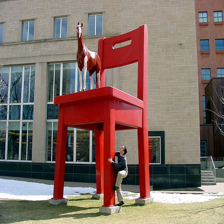

In [78]:
image

In [1]:
from transformers import pipeline

classifier = pipeline("image-classification", model="aspends/assignment", device=0, framework="tf")


predictions = classifier(image)

label_mapping = {'LABEL_0': 'cat', 'LABEL_1': 'horse'}
updated_predictions = [{'score': pred['score'], 'label': label_mapping[pred['label']]} for pred in predictions]

updated_predictions


All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at aspends/assignment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


NameError: name 'image' is not defined